# 相関ルールマイニング

以下のコードを実行して，本演習で必要なライブラリを読み込んでおきましょう．

In [2]:
require(dplyr)

# 相関ルールマイニング分析ライブラリ（要インストール）
require(arules)

# 相関ルールの可視化ライブラリ（要インストール．igraphもインストール）
require(igraph)
require(arulesViz)


---
## 演習課題

### 課題1
この演習課題では，[Instacart Market Basket Analysis](https://www.kaggle.com/c/instacart-market-basket-analysis)で公開されているデータセットを用います．適宜公開データをダウンロードし，``data/instacart``フォルダにダウンロードデータを保存したとします．

このデータセットは，食料品の即日配達サービスを運営するアメリカ企業である[Instacart](https://www.instacart.com)のウェブサイトにおける大規模な購買データが納められています．ダウンロードしたデータセットに含まれる
* order_products__train.csv（購買データが記録されたファイル）
* products.csv（購買データに現れる商品IDと商品名との対応を記したファイル）

の2ファイルを用いて，食品購買に関する相関ルールを抽出し，ある食品を購入した人に推薦すべき食品が何かを考えてください．なお，相関ルールマイニング分析で抽出する相関ルールは
* Support > 0.0001
* Confidence > 0.80

の条件を満たすものとしてください．

#### ヒント
分析対象となるトランザクションデータ（``apriori``関数に入力するデータ）は以下のコードを実行して準備してください（生データは[Instacart Market Basket Analysis](https://www.kaggle.com/c/instacart-market-basket-analysis)よりダウンロードしたものを，``data/instacart``フォルダに保存したものとする）．

In [11]:
# 生データを読み込む
instacart_df <- read.csv("data/instacart/order_products__train.csv") # 購買データ
product_df <- read.csv("data/instacart/products.csv") # 商品データ

# データが巨大なので，最初の数件のみ表示
head(instacart_df)

order_id,product_id,add_to_cart_order,reordered
1,49302,1,1
1,11109,2,1
1,10246,3,0
1,49683,4,0
1,43633,5,1
1,13176,6,0


In [12]:
# データの整形
grouped_instacart_df <- group_by(instacart_df, order_id)
instacart_purchase_df <- summarise(
    grouped_instacart_df,
    items=as.vector(list(product_id))
)

# apriori関数に入力するトランザクションデータ
instacart_transaction <- as(instacart_purchase_df$items, 'transactions')

# 計算を速くするための工夫
product_name_df <- group_by(instacart_df, product_id) %>%
    summarise(num=n()) %>%
    left_join(product_df, by='product_id') %>%
    select(product_name)

itemLabels(instacart_transaction) <- product_name_df$product_name

In [13]:
# 相関ルールマイニングの適用
instacart_rules <- apriori(instacart_transaction,
                           parameter=list(support=0.00010, confidence=0.80))

summary(instacart_rules)

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.8    0.1    1 none FALSE            TRUE       5   1e-04      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 13 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[39123 item(s), 131209 transaction(s)] done [0.46s].
sorting and recoding items ... [11554 item(s)] done [0.02s].
creating transaction tree ... done [0.06s].
checking subsets of size 1 2 3 4 5 6 done [1.01s].
writing ... [89 rule(s)] done [0.18s].
creating S4 object  ... done [0.07s].


set of 89 rules

rule length distribution (lhs + rhs):sizes
 3  4  5  6 
 5 53 28  3 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.000   4.000   4.000   4.326   5.000   6.000 

summary of quality measures:
    support            confidence          lift             count      
 Min.   :0.0001067   Min.   :0.8000   Min.   :  5.605   Min.   :14.00  
 1st Qu.:0.0001067   1st Qu.:0.8235   1st Qu.:  7.002   1st Qu.:14.00  
 Median :0.0001143   Median :0.8333   Median :  7.946   Median :15.00  
 Mean   :0.0001254   Mean   :0.8589   Mean   : 66.082   Mean   :16.45  
 3rd Qu.:0.0001296   3rd Qu.:0.8889   3rd Qu.: 34.722   3rd Qu.:17.00  
 Max.   :0.0003049   Max.   :1.0000   Max.   :950.790   Max.   :40.00  

mining info:
                  data ntransactions support confidence
 instacart_transaction        131209   1e-04        0.8

In [14]:
# リフト値上位10件の提示
inspect(head(sort(instacart_rules, by="lift"), n=10))

     lhs                                                       rhs                                                support confidence     lift count
[1]  {Unsweetened Whole Milk Peach Greek Yogurt,                                                                                                   
      Unsweetened Whole Milk Mixed Berry Greek Yogurt,                                                                                             
      Unsweetened Whole Milk Blueberry Greek Yogurt}        => {Unsweetened Whole Milk Strawberry Yogurt}    0.0001143214  0.8333333 950.7899    15
[2]  {Peach on the Bottom Nonfat Greek Yogurt,                                                                                                     
      Low-Fat Mango on the Bottom Greek Yogurt,                                                                                                    
      Strawberry on the Bottom Nonfat Greek Yogurt}         => {Blueberry on the Bottom Nonfat Greek Yogurt} 0.0

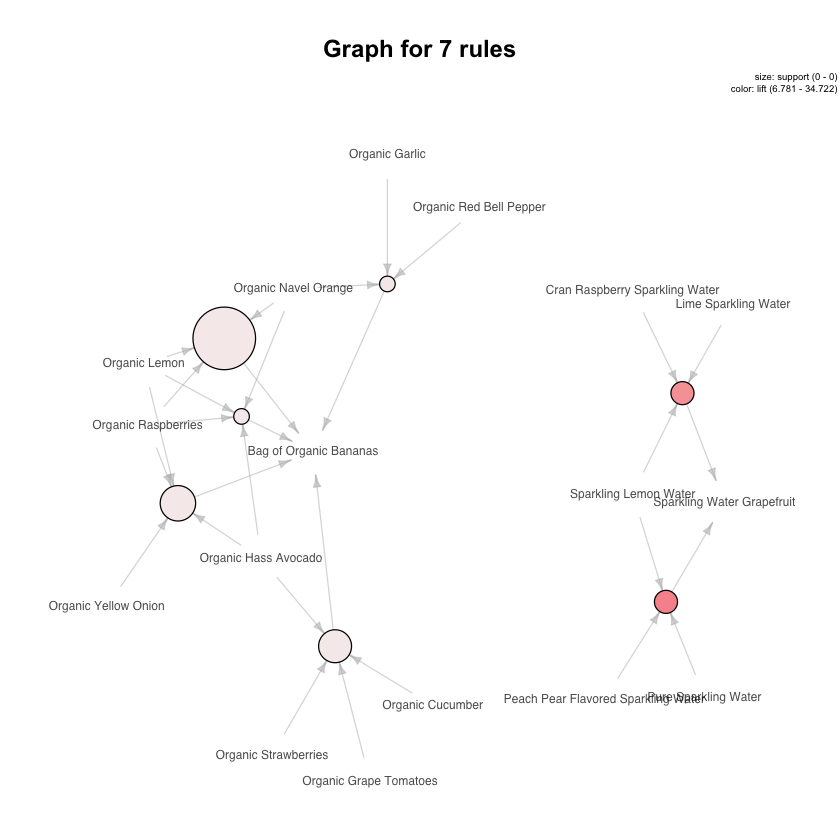

In [15]:
# サポート値が0.00016以上の相関ルールをグラフとして可視化
plot(
    subset(instacart_rules, subset=(support>0.00016)),
    method="graph",
    control=list(cex=0.6)
)